In [1]:
import time
import os

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from coffea import util
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import pandas as pd

In [2]:
JetHT_unweighted = util.load('TTbarResCoffea_JetHT_unweighted_output.coffea')
JetHT_weighted = util.load('TTbarResCoffea_JetHT_weighted_output.coffea')

JetHT2016_unweighted = util.load('TTbarResCoffea_JetHT2016_Data_unweighted_output.coffea')
JetHT2016_weighted = util.load('TTbarResCoffea_JetHT2016_Data_weighted_output.coffea')

JetHT2017_unweighted = util.load('TTbarResCoffea_JetHT2017_Data_unweighted_output.coffea')
JetHT2017_weighted = util.load('TTbarResCoffea_JetHT2017_Data_weighted_output.coffea')

JetHT2018_unweighted = util.load('TTbarResCoffea_JetHT2018_Data_unweighted_output.coffea')
JetHT2018_weighted = util.load('TTbarResCoffea_JetHT2018_Data_weighted_output.coffea')

TTbar_unweighted = util.load('TTbarResCoffea_TTbar_unweighted_output.coffea')
TTbar_weighted = util.load('TTbarResCoffea_TTbar_weighted_output.coffea')

#QCD_unweighted = util.load()

In [3]:
outputs_unweighted = {'JetHT 2016': JetHT2016_unweighted,
                      'JetHT 2017': JetHT2017_unweighted,
                      'JetHT 2018': JetHT2018_unweighted,
                      'JetHT All': JetHT_unweighted}

outputs_weighted  =  {'JetHT 2016': JetHT2016_weighted,
                      'JetHT 2017': JetHT2017_weighted,
                      'JetHT 2018': JetHT2018_weighted,
                      'JetHT All': JetHT_weighted}

In [4]:
for name,output in outputs_unweighted.items(): 
    print("-------Unweighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Unweighted JetHT 2016--------
          all events :    625516390
              jet id :    435342998
             jet kin :    122646585
two FatJets and jet kin :     53528747
     >= one oneTTbar :     42565375
          dPhi > 2.1 :     22131274
                sumw :     21404347
               sumw2 :     21404347
             At0bcen :        39347
             At0bfwd :        38756
             At1bcen :        21345
             At1bfwd :        21131
             At2bcen :         4064
             At2bfwd :         3439
             at0bcen :      1003761
             at0bfwd :      1024694
             at1bcen :       437583
             at1bfwd :       446771
             at2bcen :        51150
             at2bfwd :        50610
             0t0bcen :      6819944
             0t0bfwd :      7105628
             0t1bcen :      2537180
             0t1bfwd :      2649679
             0t2bcen :       252963
             0t2bfwd :       259320
             1t0bcen :  

In [5]:
for name,output in outputs_weighted.items(): 
    print("-------Weighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Weighted JetHT 2016--------
          all events :    625516390
              jet id :    435342998
             jet kin :    122646585
two FatJets and jet kin :     53528747
     >= one oneTTbar :     42565375
          dPhi > 2.1 :     22131274
                sumw :     21404347
               sumw2 :     21404347
             At0bcen :        39347
             At0bfwd :        38756
             At1bcen :        21345
             At1bfwd :        21131
             At2bcen :         4064
             At2bfwd :         3439
             at0bcen :      1003761
             at0bfwd :      1024694
             at1bcen :       437583
             at1bfwd :       446771
             at2bcen :        51150
             at2bfwd :        50610
             0t0bcen :      6819944
             0t0bfwd :      7105628
             0t1bcen :      2537180
             0t1bfwd :      2649679
             0t2bcen :       252963
             0t2bfwd :       259320
             1t0bcen :    

In [6]:
print("-------Unweighted TTbar--------")
for i,j in TTbar_unweighted['cutflow'].items():        
    print( '%20s : %12d' % (i,j) )

-------Unweighted TTbar--------
          all events :    142155064
              jet id :     39490224
             jet kin :      3160695
two FatJets and jet kin :      1004923
     >= one oneTTbar :       987539
          dPhi > 2.1 :       519424
                sumw :    858892291
               sumw2 : 15553874689536
             At0bcen :         1725
             At0bfwd :         1257
             At1bcen :         8203
             At1bfwd :         5131
             At2bcen :         9142
             At2bfwd :         4798
             at0bcen :         9503
             at0bfwd :         7975
             at1bcen :        31016
             at1bfwd :        23205
             at2bcen :        20826
             at2bfwd :        11448
             0t0bcen :        35713
             0t0bfwd :        34204
             0t1bcen :        72576
             0t1bfwd :        60218
             0t2bcen :        24718
             0t2bfwd :        15197
             1t0bcen :     

In [7]:
print("-------Weighted TTbar--------")
for i,j in TTbar_weighted['cutflow'].items():        
    print( '%20s : %12d' % (i,j) )

-------Weighted TTbar--------
          all events :    142155064
              jet id :     39490224
             jet kin :      3160695
two FatJets and jet kin :      1004923
     >= one oneTTbar :       987539
          dPhi > 2.1 :       519424
                sumw :    858892291
               sumw2 : 15553874689536
             At0bcen :         1725
             At0bfwd :         1257
             At1bcen :         8203
             At1bfwd :         5131
             At2bcen :         9142
             At2bfwd :         4798
             at0bcen :         9503
             at0bfwd :         7975
             at1bcen :        31016
             at1bfwd :        23205
             at2bcen :        20826
             at2bfwd :        11448
             0t0bcen :        35713
             0t0bfwd :        34204
             0t1bcen :        72576
             0t1bfwd :        60218
             0t2bcen :        24718
             0t2bfwd :        15197
             1t0bcen :       

In [8]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [9]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [10]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["at", "0t", "1t", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]

# ---- List the Histograms Here ---- #
list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep')

In [11]:
maindirectory = os.getcwd() 

In [12]:
stack_ttbar_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'red'}
stack_background_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'yellow'}
stack_error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'None', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
data_err_opts = {'linestyle': 'none', 'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1}

In [13]:
""" ---------------- Luminosity and Cross Sections ---------------- """
Lum2016 = 35920. # pb^-1 from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable
Lum2017 = 41530.
Lum2018 = 59740.
Lum     = 137190.

ttbar_BR = 0.4544 #PDG 2019
ttbar_xs = 831.76 * ttbar_BR  #pb
ttbar2016_sf = ttbar_xs*Lum2016/142155064.
ttbar2017_sf = ttbar_xs*Lum2017/142155064.
ttbar2018_sf = ttbar_xs*Lum2018/142155064.
ttbar_sf = ttbar_xs*Lum/142155064.
print(ttbar2016_sf)

qcd_xs = 1370000000.0 #pb From https://cms-gen-dev.cern.ch/xsdb

0.09550153376512849


In [14]:
Nevts2016 = 625516390. # from dasgoclient
Nevts2016_sf = Nevts2016/JetHT2016_unweighted['cutflow']['all events']
print(Nevts2016_sf)

1.0


In [15]:
# ---- Optional to rescale x-axis of mistag rates ---- #
def forward(x):
    return x**(1/2)

def inverse(x):
    return x**2

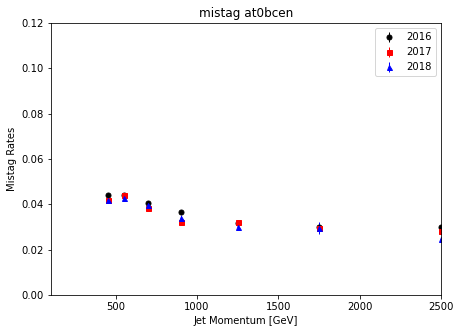

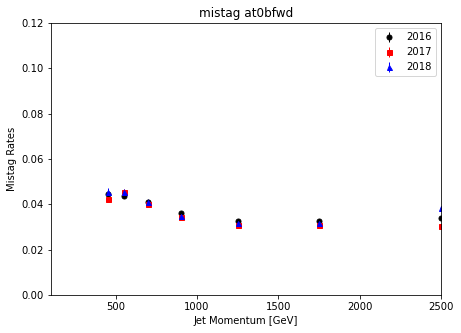

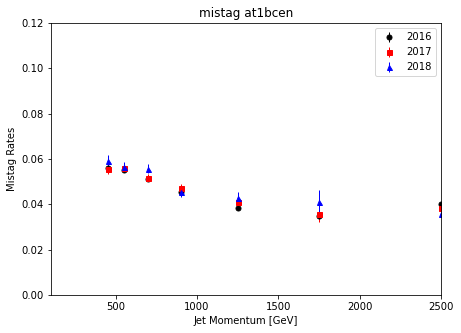

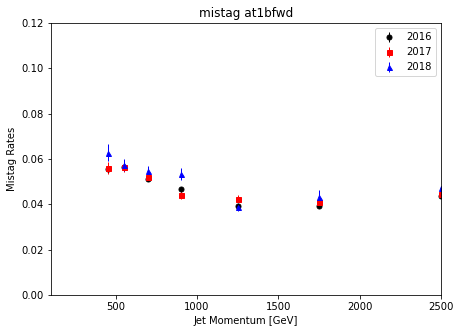

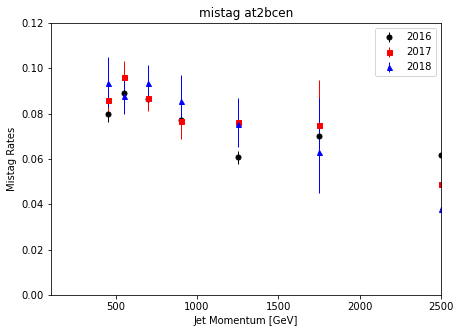

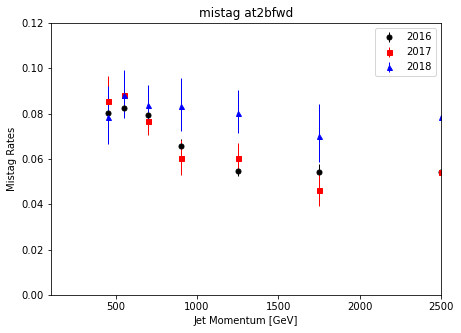

In [16]:
for icat in list_of_cats:
    if 'at' in icat:
        fig, ax = plt.subplots(
            #nrows=2,
            #ncols=1,
            figsize=(7,5),
            #gridspec_kw={"height_ratios": (3, 1)},
            sharex=True
        )
        title = 'mistag ' + icat
        
        Numerator2016 = JetHT2016_unweighted['numerator'].integrate('anacat', icat).integrate('dataset', 'JetHT2016_Data')
        Denominator2016 = JetHT2016_unweighted['denominator'].integrate('anacat', icat).integrate('dataset', 'JetHT2016_Data')
        
        Numerator2017 = JetHT2017_unweighted['numerator'].integrate('anacat', icat).integrate('dataset', 'JetHT2017_Data')
        Denominator2017 = JetHT2017_unweighted['denominator'].integrate('anacat', icat).integrate('dataset', 'JetHT2017_Data')
        
        Numerator2018 = JetHT2018_unweighted['numerator'].integrate('anacat', icat).integrate('dataset', 'JetHT2018_Data')
        Denominator2018 = JetHT2018_unweighted['denominator'].integrate('anacat', icat).integrate('dataset', 'JetHT2018_Data')
         
        mistag2016 = hist.plotratio(num = Numerator2016, denom = Denominator2016, ax=ax, clear=False,
                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                                unc = 'num')
        mistag2017 = hist.plotratio(num = Numerator2017, denom = Denominator2017, ax=ax, clear=False,
                                error_opts={'marker': 's', 'markersize': 5., 'color': 'r', 'elinewidth': 1},
                                unc = 'num')
        mistag2018 = hist.plotratio(num = Numerator2018, denom = Denominator2018, ax=ax, clear=False,
                                error_opts={'marker': '^', 'markersize': 5., 'color': 'b', 'elinewidth': 1},
                                unc = 'num')
        
        plt.ylim(bottom = 0, top = 0.12)
        plt.xlim(left = 100, right = 2500)
       
        ax.set_ylabel('Mistag Rates')
        ax.set_title(title)
        leg = ax.legend(labels=["2016", "2017", "2018"])
        
        # ---- Optional x-axis scaling ---- #
        #plt.xticks(np.array([0, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]))
        #plt.xlim(left = 100, right = 10000)
        #mistag.set_xscale('function', functions=(forward, inverse))
        #mistag.set_xscale('log')
    else:
        continue

([<matplotlib.axis.XTick at 0x7f740021cc10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

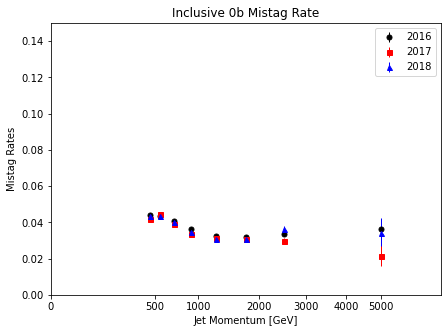

In [17]:
""" ---------- Rapidity Inclusive Mistag Rates ---------- """

btag = '0b'

fig, ax = plt.subplots(
    figsize=(7,5),
    sharex=True
)
title = 'Inclusive ' + btag + ' Mistag Rate'

Num_cen2016 = JetHT2016_unweighted['numerator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT2016_Data')
Denom_cen2016 = JetHT2016_unweighted['denominator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT2016_Data')

Num_fwd2016 = JetHT2016_unweighted['numerator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT2016_Data')
Denom_fwd2016 = JetHT2016_unweighted['denominator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT2016_Data')

Num_inc2016 = Num_cen2016.add(Num_fwd2016)
Denom_inc2016 = Denom_cen2016.add(Denom_fwd2016)
mistag_inclusive2016 = hist.plotratio(num = Num_inc2016, denom = Denom_inc2016, ax=ax, clear=False,
                                      error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                                      unc = 'num')


Num_cen2017 = JetHT2017_unweighted['numerator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT2017_Data')
Denom_cen2017 = JetHT2017_unweighted['denominator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT2017_Data')

Num_fwd2017 = JetHT2017_unweighted['numerator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT2017_Data')
Denom_fwd2017 = JetHT2017_unweighted['denominator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT2017_Data')

Num_inc2017 = Num_cen2017.add(Num_fwd2017)
Denom_inc2017 = Denom_cen2017.add(Denom_fwd2017)
mistag_inclusive2017 = hist.plotratio(num = Num_inc2017, denom = Denom_inc2017, ax=ax, clear=False,
                                      error_opts={'marker': 's', 'markersize': 5., 'color': 'r', 'elinewidth': 1},
                                      unc = 'num')



Num_cen2018 = JetHT2018_unweighted['numerator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT2018_Data')
Denom_cen2018 = JetHT2018_unweighted['denominator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT2018_Data')

Num_fwd2018 = JetHT2018_unweighted['numerator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT2018_Data')
Denom_fwd2018 = JetHT2018_unweighted['denominator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT2018_Data')

Num_inc2018 = Num_cen2018.add(Num_fwd2018)
Denom_inc2018 = Denom_cen2018.add(Denom_fwd2018)
mistag_inclusive2018 = hist.plotratio(num = Num_inc2018, denom = Denom_inc2018, ax=ax, clear=False,
                                      error_opts={'marker': '^', 'markersize': 5., 'color': 'b', 'elinewidth': 1},
                                      unc = 'num')
plt.ylim(bottom = 0, top = 0.15)
plt.xlim(left = 100, right = 7000)

ax.set_ylabel('Mistag Rates')
ax.set_title(title)
leg = ax.legend(labels=["2016", "2017", "2018"])

# ---- Optional x-axis scaling ---- #
ax.set_xscale('function', functions=(forward, inverse))
plt.xticks(np.array([0, 500, 1000, 2000, 3000, 4000, 5000]))
#ax.set_xscale('log')

([<matplotlib.axis.YTick at 0x7f740015ac90>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

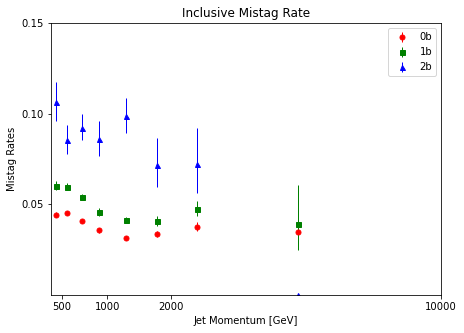

In [18]:
""" ---------- Rapidity Inclusive Mistag Rate According to b tag ---------- """

fig, ax = plt.subplots(
    figsize=(7,5),
    sharex=True
)
title = 'Inclusive Mistag Rate'

Num_cen0b = JetHT_unweighted['numerator'].integrate('anacat', 'at0bcen').integrate('dataset', 'JetHT')
Denom_cen0b = JetHT_unweighted['denominator'].integrate('anacat', 'at0bcen').integrate('dataset', 'JetHT')

Num_fwd0b = JetHT_unweighted['numerator'].integrate('anacat', 'at0bfwd').integrate('dataset', 'JetHT')
Denom_fwd0b = JetHT_unweighted['denominator'].integrate('anacat', 'at0bfwd').integrate('dataset', 'JetHT')

Num_inc0b = Num_cen0b.add(Num_fwd0b)
Denom_inc0b = Denom_cen0b.add(Denom_fwd0b)
mistag_inclusive0b = hist.plotratio(num = Num_inc0b, denom = Denom_inc0b, ax=ax, clear=False,
                                    error_opts={'marker': '.', 'markersize': 10., 'color': 'r', 'elinewidth': 1},
                                    unc = 'num')



Num_cen1b = JetHT_unweighted['numerator'].integrate('anacat', 'at1bcen').integrate('dataset', 'JetHT')
Denom_cen1b = JetHT_unweighted['denominator'].integrate('anacat', 'at1bcen').integrate('dataset', 'JetHT')

Num_fwd1b = JetHT_unweighted['numerator'].integrate('anacat', 'at1bfwd').integrate('dataset', 'JetHT')
Denom_fwd1b = JetHT_unweighted['denominator'].integrate('anacat', 'at1bfwd').integrate('dataset', 'JetHT')

Num_inc1b = Num_cen1b.add(Num_fwd1b)
Denom_inc1b = Denom_cen1b.add(Denom_fwd1b)
mistag_inclusive1b = hist.plotratio(num = Num_inc1b, denom = Denom_inc1b, ax=ax, clear=False,
                                    error_opts={'marker': 's', 'markersize': 5., 'color': 'g', 'elinewidth': 1},
                                    unc = 'num')



Num_cen2b = JetHT_unweighted['numerator'].integrate('anacat', 'at2bcen').integrate('dataset', 'JetHT')
Denom_cen2b = JetHT_unweighted['denominator'].integrate('anacat', 'at2bcen').integrate('dataset', 'JetHT')

Num_fwd2b = JetHT_unweighted['numerator'].integrate('anacat', 'at2bfwd').integrate('dataset', 'JetHT')
Denom_fwd2b = JetHT_unweighted['denominator'].integrate('anacat', 'at2bfwd').integrate('dataset', 'JetHT')

Num_inc2b = Num_cen2b.add(Num_fwd2b)
Denom_inc2b = Denom_cen2b.add(Denom_fwd2b)
mistag_inclusive2b = hist.plotratio(num = Num_inc2b, denom = Denom_inc2b, ax=ax, clear=False,
                                    error_opts={'marker': '^', 'markersize': 5., 'color': 'b', 'elinewidth': 1},
                                    unc = 'num')
plt.ylim(bottom = 0, top = 0.15)
plt.xlim([400,10000])

ax.set_ylabel('Mistag Rates')
ax.set_title(title)
leg = ax.legend(labels=["0b", "1b", "2b"])

# ---- Optional x-axis scaling ---- #
ax.set_xscale('function', functions=(forward, inverse))
plt.xticks(np.array([500, 1000, 2000, 10000]))
plt.yticks(np.array([.05, .10, .15]))
#ax.set_xscale('log')

Mean Mistag Rate (MMR) =  0.03499475009193819
Number of Data (Cutflow) =        1003761
Number of Background (Cutflow) =  1003761

              p      M(p)  unwgt at0bcen MC  wgt at0bcen MC  At0bcen MC
0    [400, 500)  0.043900          132801.0     5830.000000      5830.0
1    [500, 600)  0.043968          217997.0     9584.999932      9585.0
2    [600, 800)  0.040442          300285.0    12144.003527     12144.0
3   [800, 1000)  0.036428          150790.0     5493.000000      5493.0
4  [1000, 1500)  0.031611          146785.0     4640.000000      4640.0
5  [1500, 2000)  0.030110           41149.0     1239.000000      1239.0
6  [2000, 3000)  0.029969           13614.0      408.000000       408.0
7  [3000, 7000)  0.023529             340.0        8.000000         8.0


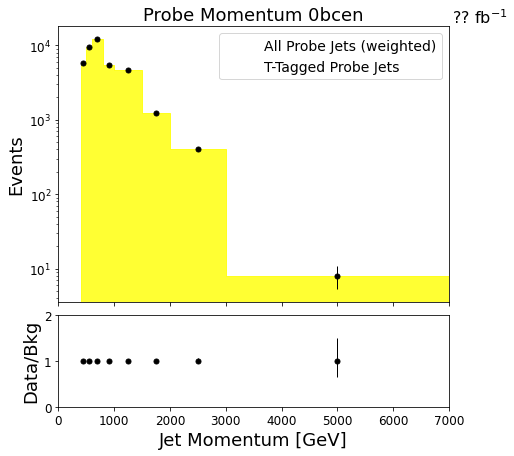

In [19]:
""" ---------- Comparing Background Estimate to unweighted Data ---------- """
SaveDirectory = maindirectory + '/' + 'ClosureTests' + '/' # split histograms into subdirectories
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already

#---- Histogram Window Config. ----# 
plt.rcParams.update({
'font.size': 14,
'axes.titlesize': 18,
'axes.labelsize': 18,
'xtick.labelsize': 12,
'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)
b_y = '0bcen' # b-tag category and rapidity window

#---- Useful Information ----# 
lut_file = maindirectory + '/LookupTables/mistag_JetHT2016_Data_at' + b_y + '.csv'
df = pd.read_csv(lut_file)
p_vals = df['p']
mtr = df['M(p)'].values
MMR = mtr.sum()/mtr.size
print('Mean Mistag Rate (MMR) = ', MMR)

#---- Check if these two cutflows are the same ----#
nevts = JetHT2016_unweighted['cutflow']['at'+b_y]
bkg_nevts = JetHT2016_weighted['cutflow']['at'+b_y]

print('Number of Data (Cutflow) =       ', nevts)
print('Number of Background (Cutflow) = ', bkg_nevts)
print()

#---- Define Histogram categories of interest ----# 
hist_wgt_anacat = 'at' + b_y # category of interest for the weighted data (all weighted probe jets)
hist_unwgt_anacat = 'At' + b_y # category of interest for the un-weighted data (unweighted t-tagged probe jets)
hist_unwgt_pretag_anacat = 'at' + b_y # (all unweighted probe jets)

#---- Given pairs of jets where one jet is anti-tagged, show the momentum of the probe jets ----#
MC_hist_wgt = JetHT2016_weighted['probep'].integrate('anacat', hist_wgt_anacat).integrate('dataset', 'JetHT2016_Data')
MC_hist_unwgt = JetHT2016_unweighted['probep'].integrate('anacat', hist_unwgt_anacat).integrate('dataset', 'JetHT2016_Data')
MC_hist_unwgt_pretag = JetHT2016_unweighted['probep'].integrate('anacat', hist_unwgt_pretag_anacat).integrate('dataset', 'JetHT2016_Data')

hist.plot1d(MC_hist_wgt, ax=ax, clear=True,
                    fill_opts=stack_background_opts, error_opts=stack_error_opts) # all probe jets weighted with mistag
hist.plot1d(MC_hist_unwgt, ax=ax, clear=False,
                    error_opts=data_err_opts) # all unweighted, t-tagged probe jets

d = {'p': p_vals, 'M(p)': mtr, 
     'unwgt at0bcen MC': MC_hist_unwgt_pretag.values()[()], 
     'wgt at0bcen MC': MC_hist_wgt.values()[()], 
     'At0bcen MC': MC_hist_unwgt.values()[()]}
df1 = pd.DataFrame(data=d)
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(df1)

ax.set_yscale('log')
ax.autoscale('y')
ax.autoscale('x')#, tight=True) # doesn't look like its working...
ax.set_ylabel('Events')
ax.set_xlabel(None)
ax.set_title('Probe Momentum ' + b_y)
leg = ax.legend(labels=["All Probe Jets (weighted)", "T-Tagged Probe Jets"])

#---- Plot Ratio ----#
hist.plotratio(num = MC_hist_unwgt, denom = MC_hist_wgt, ax = rax,
               error_opts=data_err_opts,
               unc = 'num')
rax.set_ylabel('Data/Bkg')
rax.set_ylim(0,2)

#---- Labeling ----#
lumi = plt.text(1.15, 1.07, "?? fb$^{-1}$",
        fontsize=16,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes
       )

Background Estimate Region # of Entries =  569955
Signal Region # of Entries =               11784


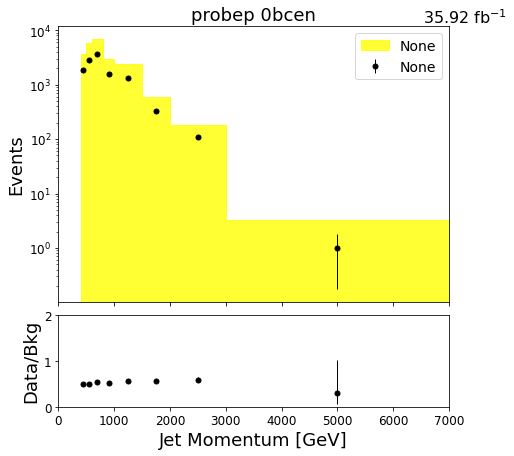

In [20]:
""" ---------- Comparing Background Estimate to Unweighted Data (Checks One Histogram) ---------- """
""" --------------- Background: t tagged probe jet from data weighted by mistag --------------- """
""" --------------- Data: Unweighted Data from the Signal Region (2t tag region) -------------- """
 
plt.rcParams.update({
'font.size': 14,
'axes.titlesize': 18,
'axes.labelsize': 18,
'xtick.labelsize': 12,
'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)

#---- Name of Histogram to plot ----#
name = 'probep'
btag = '0b'
yreg = 'cen'

#---- Print cutflow of events ----#
bkg_nevts = JetHT2016_weighted['cutflow']['1t'+btag+yreg] + JetHT2016_weighted['cutflow']['2t'+btag+yreg]
sig_nevts = JetHT2016_unweighted['cutflow']['2t'+btag+yreg]
print("Background Estimate Region # of Entries = ", bkg_nevts)
print("Signal Region # of Entries =              ", sig_nevts)

#---- Define Histograms ----# 
Data_hist_wgt_1 = JetHT2016_weighted[name].integrate('anacat', '1t'+btag+yreg).integrate('dataset', 'JetHT2016_Data')
Data_hist_wgt_2 = JetHT2016_weighted[name].integrate('anacat', '2t'+btag+yreg).integrate('dataset', 'JetHT2016_Data')
Data_hist_unwgt = JetHT2016_unweighted[name].integrate('anacat', '2t'+btag+yreg).integrate('dataset', 'JetHT2016_Data')
Data_hist_preunwgt = JetHT2016_unweighted[name].integrate('anacat', '1t'+btag+yreg).integrate('dataset', 'JetHT2016_Data')

Background = Data_hist_wgt_1.add(Data_hist_wgt_2) # 1t and 2t region weighted by mistag
Signal = Data_hist_unwgt # 2t region unweighted data

# ---- Scale Histograms ---- #
Background.scale(Nevts2016_sf)
Signal.scale(Nevts2016_sf)

# ---- Legend Lables ---- #
#legend_labels = {'labels':['', '', 'Background', 'Signal'], 'ncol':2}

# ---- Plot Histograms ---- #
BackgroundPlot = hist.plot1d(Background, ax=ax, clear=True,
            fill_opts=stack_background_opts,
            error_opts=stack_error_opts)
SignalPlot = hist.plot1d(Signal, ax=ax, clear=False,
            error_opts=data_err_opts)
            #legend_opts=legend_labels)

plt.ylim(bottom = .1, top = 10**4)
plt.xlim([400,10000])

ax.set_yscale('log')
ax.autoscale('y')
ax.autoscale('x')#, tight=True) # doesn't look like its working...
ax.set_ylabel('Events')
ax.set_xlabel(None)
ax.set_title(name + ' ' + btag + yreg)
ax.legend()

#---- Plot Ratio ----#
RatioPlot = hist.plotratio(num = Signal, denom = Background, ax = rax,
               error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
               unc = 'num')
rax.set_ylabel('Data/Bkg')
rax.set_ylim(0,2)

#---- Labeling ----#
Lint = str(Lum2016*.001) # Integrated Luminosity
lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
        fontsize=16,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes
       )
#NBkg = np.sum(Background.integrate(name).values()) # extract number of events from histogram directly
#NBkg = [i for i in NBkg.values()][0]
#print("Background # of Calculated Events = ", NBkg)

Background Estimate Region # of Entries =  21648
Signal Region # of Entries =               1914


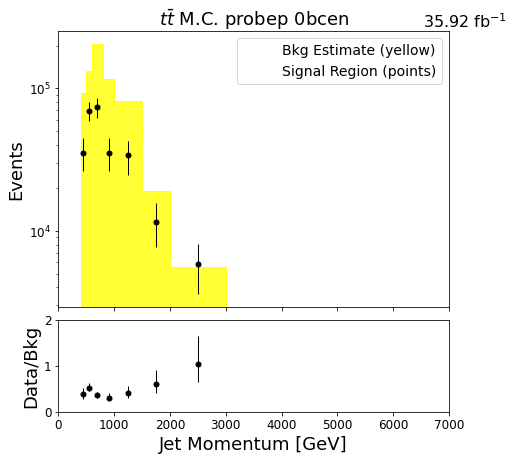

In [21]:
""" ---------- TTbar MC Background Estimate ---------- """

plt.rcParams.update({
'font.size': 14,
'axes.titlesize': 18,
'axes.labelsize': 18,
'xtick.labelsize': 12,
'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)

#---- Name of Histogram to plot ----#
name = 'probep'
btag = '0b'
yreg = 'cen'

#---- Print cutflow of events ----#
bkg_nevts = TTbar_weighted['cutflow']['1t'+btag+yreg] + TTbar_weighted['cutflow']['2t'+btag+yreg]
sig_nevts = TTbar_unweighted['cutflow']['2t'+btag+yreg]
print("Background Estimate Region # of Entries = ", bkg_nevts)
print("Signal Region # of Entries =              ", sig_nevts)

#---- Define Histograms ----# 
Data_hist_wgt_1 = TTbar_weighted[name].integrate('anacat', '1t'+btag+yreg).integrate('dataset', 'TTbar')
Data_hist_wgt_2 = TTbar_weighted[name].integrate('anacat', '2t'+btag+yreg).integrate('dataset', 'TTbar')
Data_hist_unwgt = TTbar_unweighted[name].integrate('anacat', '2t'+btag+yreg).integrate('dataset', 'TTbar')
Data_hist_preunwgt = TTbar_unweighted[name].integrate('anacat', '1t'+btag+yreg).integrate('dataset', 'TTbar')

Background = Data_hist_wgt_1.add(Data_hist_wgt_2)
Signal = Data_hist_unwgt

# ---- Scale MC according to Luminosity ---- #
Background.scale(ttbar2016_sf)
Signal.scale(ttbar2016_sf)

# ---- Plot Histograms ---- #
hist.plot1d(Background, ax=ax, clear=True,
                    fill_opts=stack_background_opts,
                    error_opts=stack_error_opts)
hist.plot1d(Signal, ax=ax, clear=False,
                    error_opts=data_err_opts)

ax.set_yscale('log')
ax.autoscale('y')
ax.autoscale('x')#, tight=True) # doesn't look like its working...
ax.set_ylabel('Events')
ax.set_xlabel(None)
ax.set_title(r'$t\bar{t}$ M.C. ' + name + ' ' + btag + yreg)
leg = ax.legend(labels=["Bkg Estimate (yellow)", "Signal Region (points)"])

#---- Plot Ratio ----#
hist.plotratio(num = Signal, denom = Background, ax = rax,
               error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
               unc = 'num')
rax.set_ylabel('Data/Bkg')
rax.set_ylim(0,2)

#---- Labeling ----#
Lint = str(Lum2016*.001) # Integrated Luminosity
lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
        fontsize=16,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes
       )
#NBkg = np.sum(Background.integrate(name).values()) # extract number of events from histogram directly
#NBkg = [i for i in NBkg.values()][0]
#print("Background # of Calculated Events = ", NBkg)